# Predicting Movie Success using Posters
---
### Model:
    Deep Convolutional Neural Network

### Developers:

    Bardia Borhani  
    Kevin Ulrich

### Project Goals:
1. Create a working deep convolutional neural network
2. Train the network given posters from the [The Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset)
3. See what performance can be achieved from model predictions given new posters
4. Bonus: Try out other models. Ensemble models.

# Setup Environment

We import numpy and pandas here for all our data processing needs, and then we specify the input location, and check what files are in the input folder.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from print_head_tail import head, tail
from plot_images import show_images
import os

In [2]:
input_loc = '../input/movie_dataset'

print(os.listdir(input_loc))

['links_small.csv', 'the-movies-dataset.zip', 'ratings.csv', 'links.csv', 'keywords.csv', 'credits.csv', 'ratings_small.csv', 'movies_metadata.csv']


# Import Data

We then read in the data from the movies_metadata file. We output the first few rows of the file just to preview it.

In [3]:
metadata = pd.read_csv(input_loc + '/movies_metadata.csv', low_memory=False)

# preview the data
head(metadata, 3)

**whole table (below):** 45466 rows × 24 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


# Column Data Types
Some of the columns are read in as an incorrect data type. Some of the data appears to be shifted, since the error that occurs if we try to set the dtype for our numeric columns explicitly is a poster path (a string) - data that shouldn't be in any of the numeric columns.

Pandas isn't so hot at just bypassing errors or coercing them when it's reading in a CSV, but it has a to_numeric method that we can use after we read the file in. Let's do that now.

In [4]:
# Let's see which columns are bad
print('before:')
print(type(metadata.budget[0]))
print(type(metadata.revenue[0]))
print(type(metadata.popularity[0]))
print(type(metadata.vote_average[0]))
print(type(metadata.vote_count[0]))

# fix the bad columns
metadata.budget = pd.to_numeric(metadata.budget, errors='coerce')
metadata.popularity = pd.to_numeric(metadata.popularity, errors='coerce')

print('\nafter:')
# check if the conversions worked
print(type(metadata.budget[0]))
print(type(metadata.revenue[0]))
print(type(metadata.popularity[0]))
print(type(metadata.vote_average[0]))
print(type(metadata.vote_count[0]))

before:
<class 'str'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>

after:
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


Continuing in the theme of checking our data, let's see all the header names, which helps us locate (loc or iloc) our data by column when we want to go through it row by row.

In [5]:
# what are the column names?
first_movie = metadata.iloc[[0]]
for key, value in first_movie.items() :
    print(key)

adult
belongs_to_collection
budget
genres
homepage
id
imdb_id
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
video
vote_average
vote_count


# Bad Data
When we downloaded our data later in this script, we realized that there were a lot of posters that didn't have any extensions, and therefore were not images. Even appending an extension didn't make them work. Going back to the metadata csv, we realized that some of the rows simply don't have a poster path. Below is an example of a good row and a bad row.

In [6]:
# there are some movies that don't have posters... we'll deal with these later
print(str(metadata.iloc[[38802]]['poster_path']))
print(str(metadata.iloc[[44660]]['poster_path']))

38802    /sLvzxFBH5vGFei8oUNzDVwHKGdl.jpg
Name: poster_path, dtype: object
44660    NaN
Name: poster_path, dtype: object


# Scrape Posters

The script below scrapes all the posters from the TMDB website. Note that we are downloading the images with a set width of 780. Hopefully this will mean that all the posters will be the same size. Other sizes that we could do would be `w500` or `original`, just by replacing wherever `w780` appears in the script.

The only error checking we do is for illegal (NaN) and non-jpg poster paths. We exclude these from the dataset, and don't download the files. We also recreate our metadata DataFrame in memory to only include good data (rows with poster paths).

This script takes about 5 hours to download the ~45,000 posters at 780 width. I've heard things about using sessions with the requests library, but didn't care enough to look into it. If the dataset were larger, that might be a good idea.

In [7]:
# get all movie posters

# imports
import requests
import math
from tqdm import tqdm_notebook

# create a directory for the poster images to reside
poster_dir = 'poster_imgs/'
if not os.path.exists(poster_dir):
    os.makedirs(poster_dir)
    
good_metadata = []
file_index = 0

# for each row of data
for index, row in tqdm_notebook(list(metadata.iterrows())):
    
    # build the file path
    posterpath = row['poster_path']
    if type(posterpath) != str or '.jpg' not in posterpath:
        
        # bad data, skip it
        continue
        
    else:
        
        filename = str(file_index) + '.jpg' # ignore the given file extension, it might be non-existent
        filepath = poster_dir + filename

        # if we haven't downloaded the file yet
        if not os.path.exists(filepath):

            # download the movie poster from tmdb using the poster path
            # and save it locally
            url = 'http://image.tmdb.org/t/p/w780' + posterpath
            r = requests.get(url, allow_redirects=True)
            open(filepath, 'wb').write(r.content)
            
        good_metadata.append(row)
        file_index += 1

print('size of metadata before removing bad rows: ', len(metadata))
tail(metadata, 3)
metadata = pd.DataFrame(good_metadata)
metadata.index = range(len(metadata.index))
print('size of metadata having removed bad rows: ', len(metadata))
tail(metadata, 3)

# store the total number of images we have on disk
total_images = len(metadata)

HBox(children=(IntProgress(value=0, max=45466), HTML(value='')))


size of metadata before removing bad rows:  45466


**whole table (below):** 45466 rows × 24 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
45463,False,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0.0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0
45465,False,NaN,0.0,[],NaN,461257,tt6980792,en,Queerama,50 years after decriminalisation of homosexual...,...,2017-06-09,0.0,75.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Queerama,False,0.0,0.0


size of metadata having removed bad rows:  45069


**whole table (below):** 45069 rows × 24 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
45066,False,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45067,False,NaN,0.0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0
45068,False,NaN,0.0,[],NaN,461257,tt6980792,en,Queerama,50 years after decriminalisation of homosexual...,...,2017-06-09,0.0,75.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Queerama,False,0.0,0.0


# Load in the Data

Now that we've scraped the posters, it's time to load them into memory so we can give them to our neural network to train it.

The function we use to preview our images is from [here](https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1)

number of files in the poster directory:  45069
number of files in the poster directory that are jpgs:  45069

number of rows of metadata:  45069
number of images that we have in memory:  45069


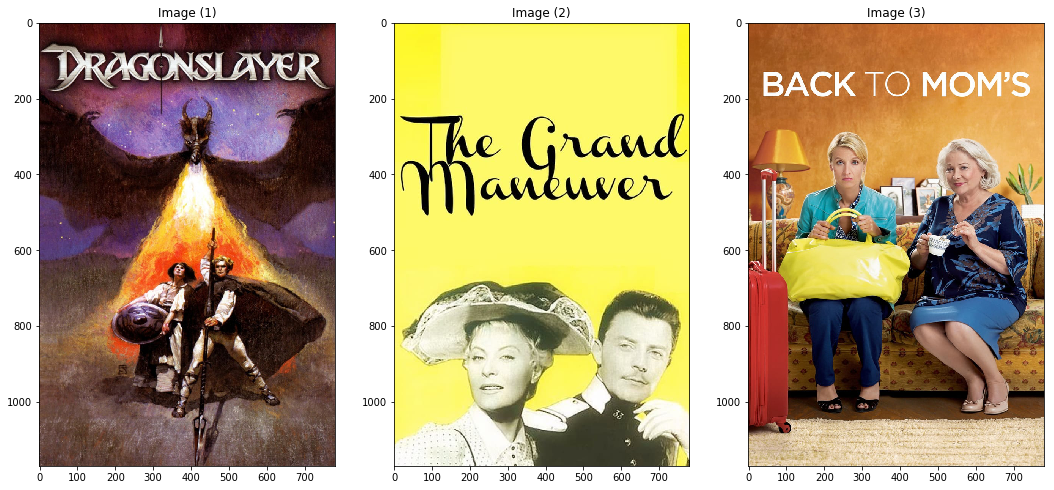

In [8]:
import skimage
import skimage.io as io
import skimage.transform
from skimage import data
import sys
%matplotlib inline

# read in filenames
files = []
for (dirpath, dirnames, filenames) in os.walk(poster_dir):
    files.extend(filenames)
    break
    
print('number of files in the poster directory: ', len(files))

# remove any of the files if they aren't jpgs
filtered_files = []
for filename in files:
    if '.jpg' in filename:
        filtered_files.append(filename)
        
print('number of files in the poster directory that are jpgs: ', len(filtered_files))

# prepend the filepath to the filenames
filtered_files = [(poster_dir + '{0}').format(i) for i in filtered_files]

# read in the images
images = io.imread_collection(list(filtered_files), conserve_memory=True)

# these lengths should be the same
print('\nnumber of rows of metadata: ', len(metadata))
print('number of images that we have in memory: ', len(images))

# show the first few posters to make sure we have the data
show_images(images[0:3]);

# Defining Success

There are multiple columns in the dataset that we might be able to use to decide a movie's success.

The ones of note are:
* budget
* popularity
* revenue
* vote_average
* vote_count

One of the main things to factor in is likely return on investment (ROI), and it's percentage related to the movie's budget. We can find this through the following equation:  
$$\frac{Revenue - Budget}{Budget}$$

Success in our case will be a boolean (0/1) variable, so we want to include any of the other considered factors into our calculations. For now let's do a little bit of exploration and see what ROI tells us about the success of a movie.

In [9]:
# Find ROI for each row
rois = []
for index, row in tqdm_notebook(list(metadata.iterrows())):
    if row.budget != 0:
        rois.append((row.revenue - row.budget) / row.budget)
    else:
        rois.append(0)
        
metadata['roi'] = rois

head(metadata, 5)

HBox(children=(IntProgress(value=0, max=45069), HTML(value='')))

**whole table (below):** 45069 rows × 25 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,roi
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,11.451801
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3.043035
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,0.000000
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,4.090760
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,0.000000


Now that we have a column in the dataframe to represent ROI, let's check what might constitute a "successful" movie using only this metric.

In [10]:
print('Movies with over 10% ROI: ', len(metadata[(metadata['roi']>10)]), ' out of ', len(metadata['roi']))

print('Movies with over 5% ROI: ', len(metadata[(metadata['roi']>5)]), ' out of ', len(metadata['roi']))

print('Movies with over 1% ROI: ', len(metadata[(metadata['roi']>1)]), ' out of ', len(metadata['roi']))

Movies with over 10% ROI:  401  out of  45069
Movies with over 5% ROI:  895  out of  45069
Movies with over 1% ROI:  2743  out of  45069


# Problems with ROI
There's very few movies out of our total population of 45k that have even over 10% ROI. You may have noticed that some of the movies have no budget or revenue. Let's check a couple things in our data, specifically how many movies have 0 for budget, and how many have 0 for revenue. Hopefully those two numbers match up.

In [11]:
print('Movies where the budget is 0: ', len(metadata[(metadata['budget']==0)]))

print('Movies where the revenue is 0: ', len(metadata[(metadata['revenue']==0)]))

head(metadata[(metadata['budget']==0)], 3)

head(metadata[(metadata['revenue']==0)], 3)

Movies where the budget is 0:  36186
Movies where the revenue is 0:  37663


**whole table (below):** 36186 rows × 25 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,roi
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,0.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,0.0
7,False,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,0.0


**whole table (below):** 37663 rows × 25 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,roi
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,0.0
6,False,NaN,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0,-1.0
7,False,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,0.0


# ROI Alternatives

We note that one of the first listed movies, Father of the Bride Part II, has a budget of \$0, but a revenue of \$76,578,911... Which doesn't really add up. Similarly, Sabrina has a budget of \$58,000,000 but a revenue of \$0 (that must have been rough).

This tells us we either need to do some more data processing, to get rid of invalid entries, or we shouldn't use revenue as a metric for movie success.

Since entries with either one or both columns being 0 is over 80% of our data, it seems like a bad idea to prune so much of the dataset. Rather, we need to take a look at what other data we have that could supplement or replace our ROI metric.

In [12]:
print('Movies where vote average is over 6 out of 10: ', len(metadata[(metadata['vote_average']>6)]))

print('Movies where vote count is greater than 100: ', len(metadata[(metadata['vote_count']>100)]))

print('Movies where both are true: ', len(metadata[(metadata['vote_count']>100) & (metadata['vote_average']>6)]))

Movies where vote average is over 6 out of 10:  21726
Movies where vote count is greater than 100:  6020
Movies where both are true:  4002


# Popularity

Let's also take a look at the last metric that might be useful, popularity.

In [13]:
print(metadata.popularity.describe())
print('Movies where popularity is over 100: ', len(metadata[(metadata['popularity'] > 100)]))

count    45069.000000
mean         2.946109
std          6.025522
min          0.000000
25%          0.400813
50%          1.143067
75%          3.733898
max        547.488298
Name: popularity, dtype: float64
Movies where popularity is over 100:  16


The data makes basically no sense, since our min is 0 and our max is... 547? The Kaggle site that describes the dataset has no answers for this very strange scaling. Notice that only 16 movies are over 100 popularity. The mean tells us most are around 3.

Even looking at [this link](https://www.kaggle.com/tmdb/tmdb-movie-metadata/discussion/50548) and [this one](https://developers.themoviedb.org/3/getting-started/popularity) didn't help explain the purpose of popularity, at least specifically in the dataset we're using.

In other words it appears that popularity is not useful.

# Success column
Let's add a column to the Pandas dataframe for testing/validation. We will use the criteria that was defined just above:
1. Average vote must be over 6
2. Number of votes must be over 100 to make sure that the average is legit

In [14]:
# Find success for each row
success = []
for index, row in tqdm_notebook(list(metadata.iterrows())):
    if row.vote_average > 6 and row.vote_count > 100:
        success.append(1)
    else:
        success.append(0)
        
metadata['success'] = success

head(metadata, 5)

HBox(children=(IntProgress(value=0, max=45069), HTML(value='')))

**whole table (below):** 45069 rows × 26 columns

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,roi,success
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,11.451801,1
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3.043035,1
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,0.000000,0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,4.090760,0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,0.000000,0


In [15]:
# input_batch_size = 1000

# # ravel a batch of images
# input_data = []
# for image in tqdm_notebook(images[0:input_batch_size]):
#     input_data.append(np.ravel(image))

# # turn the list into an numpy array
# input_data = np.array(input_data)

In [40]:
# let's preprocess the images - basically just loading them in as a flow
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# the keras directory flow needs the images to be 'labelled' by being in subfolders

# first we randomize the dataframe
metadata = shuffle(metadata)

# and then we split the metadata into train, test, and validation sets
train_data, test_data = train_test_split(metadata, test_size=0.3)
test_data, val_data = train_test_split(test_data, test_size=0.3)

# method to create a folder, will overwrite if the folder
# already exists
def create_folder(path):
    
    # make or overwrite the necessary folder
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

# method to create the subfolders and copy the images
# into the correct subfolder based on the success column
def sort_images(path, data):
    
    create_folder(path + 'success/')
    create_folder(path + 'unsuccess/')
    
    # go through the metadata
    for index, row in tqdm_notebook(list(data.iterrows())):
        if row.success == 1:
            shutil.copyfile(poster_dir + str(index) + '.jpg', path + 'success/' + str(index) + '.jpg')
        else:
            shutil.copyfile(poster_dir + str(index) + '.jpg', path + 'unsuccess/' + str(index) + '.jpg')
            
# define all the folders we need
train_dir = poster_dir + 'train/'
test_dir = poster_dir + 'test/'
val_dir = poster_dir + 'val/'

# create the necessary folders
create_folder(train_dir)
create_folder(test_dir)
create_folder(val_dir)

# sort the images into the folders
sort_images(train_dir, train_data)
sort_images(test_dir, test_data)
sort_images(val_dir, val_data)

HBox(children=(IntProgress(value=0, max=31548), HTML(value='')))

unsuccess
unsuccess
unsuccess
success
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsu

unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
success
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsucc

unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsucc

unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess


unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsucc

unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
success
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsuccess
unsu

KeyboardInterrupt: 

In [29]:
from keras.preprocessing.image import ImageDataGenerator

# define image sizes
image_width = 32
image_height = 32
image_size = image_width * image_height

# create the image data generator
# datagen = ImageDataGenerator(rescale=1./255)
datagen = ImageDataGenerator()

image_batch_size = 1000

# create one for the training set
train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=image_batch_size,
        class_mode='binary')

# as well as for the validation set
validation_generator = datagen.flow_from_directory(
        val_dir,
        target_size=(image_width, image_height),
        batch_size=image_batch_size,
        class_mode='binary')

Found 31548 images belonging to 2 classes.
Found 4057 images belonging to 2 classes.


# Model
We're going to follow [this guide](https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8) to create our convolutional neural network. Notice that we are not creating a deep CNN, as there's only one convolution layer. Note also that we changed our output activation function to softmax.

In [38]:
# now we initialize the neural net
import os.path
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

if os.path.exists('cnn_weights.h5'):
    
    print('loading in precompiled model...')
    model = load_model('cnn_weights.h5')
    print('done')
    
else:

    print('creating and training new model')
    # create model
    model = Sequential()

    # convolutional layer
    model.add(Conv2D(10, (3, 3), input_shape=(image_width, image_height, 3), activation='relu'))

    # max pooling layer
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # flatten layer
    model.add(Flatten())

    # first dense layer
    model.add(Dense(units = 128, activation = 'relu'))

    # output layer
    model.add(Dense(units = 1, activation = 'softmax'))

    # print out a summary of the neural network
    model.summary()

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit from flow
    model.fit_generator(
            train_generator,
            steps_per_epoch=10,
            epochs=5,
            validation_data=validation_generator,
            validation_steps=100)
    
    # save the model on disk
    model.save("cnn_weights.h5")

loading in precompiled model...
done


In [35]:
# test generator
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(image_width, image_height),
        batch_size=image_batch_size,
        class_mode='binary')

# predict
predictions = model.evaluate_generator(test_generator)

# i = 0
# total = len(predictions)
# sum = 0;
# # print predictions
# for p in predictions:
#     predicted_label = max(enumerate(p), key=(lambda x: x[1]))[0] + 1
#     print(predicted_label)
#     print(predicted_label == labels[i])
#     if(predicted_label == labels[i]):
#         sum += 1
#     i += 1
    
# accuracy = sum / total;
# print("accuracy: ", accuracy * 100, "% correct")

Found 9464 images belonging to 2 classes.
number of predictions:  2
first prediction:  1.1920930376163597e-07


In [36]:
print("number of predictions: ", len(predictions))

print('predictions: ', predictions)

number of predictions:  2
predictions:  [1.1920930376163597e-07, 1.0]
